In [1]:
import reactord as rd
import reactord.flowreactors.stationary_1d.pfr as pfr

import numpy as np

import matplotlib.pyplot as plt

In [5]:
def cpa(t, p):
    return np.full(len(t), 163)

def cpb(t, p):
    return np.full(len(t), 83)

def cpc(t,p):
    return np.full(len(t), 71)

def int_cpa(t1, t2, p):
    return 163 * (t2 - t1)

def int_cpb(t1, t2, p):
    return 83 * (t2 - t1)

def int_cpc(t1, t2, p):
    return 71 * (t2 - t1)

def r_rate(c, t, cons):
    k = 3.58 * np.exp(34222 * (1 / 1035 - 1 / t))
    return k * c["acetone"]

a = rd.Substance(
    "acetone", formation_enthalpy_ig=-216.67*1000, heat_capacity_gas=cpa, heat_capacity_gas_dt_integral=int_cpa
)

b = rd.Substance(
    "anhydride", formation_enthalpy_ig=-61.09*1000, heat_capacity_gas=cpb, heat_capacity_gas_dt_integral=int_cpb
)

c = rd.Substance(
    "methane", formation_enthalpy_ig=-74.81*1000, heat_capacity_gas=cpc, heat_capacity_gas_dt_integral=int_cpc
)

mix = rd.mix.IdealGas([a, b, c])

kinetic = rd.Kinetic(
    mix=mix,
    reactions={"r1": {"eq": a > b + c, "rate": r_rate}},
    kinetic_constants={},
    rates_argument="concentration",
)

mb = pfr.mass_balances.MolarFlow(
    molar_flows_in={"acetone": 0.0376, "anhydride": 0, "methane": 0},
)
eb = pfr.energy_balances.NoIsothermicAllConstant(
    temperature_in_or_out={"in": 1035},
    refrigerant_in_temperature=1250,
    heat_exchange_coefficient=110
)
pb = pfr.pressure_balances.Isobaric(162 * 1000)

area = np.pi * (4 / (16500 / 110))**2 / 4

reactor = pfr.PFR(
    kinetic=kinetic,
    reactor_length=1 / 1000 / area,
    transversal_area=area,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb,
)

reactor.simulate(method="LSODA")

# Fogler data
t_z = np.array([0.0159,	0.0398,	0.0677,	0.0956,	0.1275,	0.1753,	0.2191,	0.259,	0.3028,	0.3506,	0.3904,	0.4382,	0.4821,	0.5498,	0.6215,	0.6773,	0.749,	0.8287,	0.8924,	0.9522,	0.996]) / 1000 / area
t = np.array([1033.93,	1030.44,	1030.44,	1031.31,	1032.62,	1035.24,	1037.86,	1040.49,	1043.54,	1047.04,	1050.10,	1053.59,	1057.09,	1062.33,	1068.45,	1073.25,	1080.24,	1088.98,	1097.28,	1106.46,	1113.88])

x_z = np.array([0.0121,	0.0684,	0.1206,	0.193,	0.2814,	0.3537,	0.426,	0.4983,	0.5705,	0.6428,	0.719,	0.8073,	0.9036,	0.9958]) / 1000 / area
x = np.array([0.0194,	0.0922,	0.1553,	0.2427,	0.3398,	0.4223,	0.4951,	0.568,	0.6311,	0.6942,	0.7524,	0.8204,	0.8883,	0.9466])

rd_temps = reactor.temperature_profile
rd_facetone = reactor.mass_profile[0]
rd_x = (0.0376 - rd_facetone) / (0.0376)

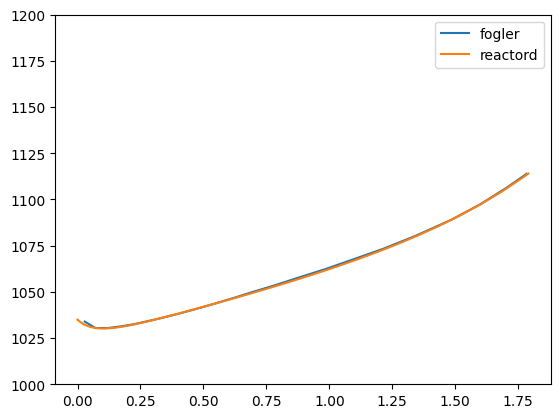

In [6]:
plt.plot(t_z, t, label="fogler")

plt.plot(reactor.z, reactor.temperature_profile, label="reactord")

#plt.xlim(0, 1 / 1000 / area)

plt.ylim(1000, 1200)

plt.legend()

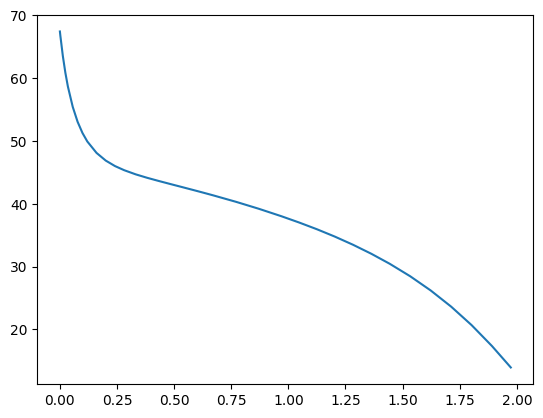

In [4]:
plt.plot(reactor.z, reactor.r_rates_profile[0])